In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
'''products=['prod A','prod B','prod C','prod D','prod E']
data={
    'Product':np.random.choose(products,size=20)
    'Quantity':np.random.randint()
}'''

"products=['prod A','prod B','prod C','prod D','prod E']\ndata={\n    'Product':np.random.choose(products,size=20)\n    'Quantity':np.random.randint()\n}"

In [3]:
# synthetic_product_sales_generator.py
import numpy as np
import pandas as pd

# ------- CONFIG -------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N_ROWS = 3500            # change between 3000 and 4000 as you like
NULL_FRAC_RANGE = (0.01, 0.05)   # fraction (1% to 5%) of random nulls per column
OUTLIER_FRAC = 0.008     # fraction (~0.8%) rows to convert into outliers
OUTPUT_CSV = "synthetic_product_sales.csv"

# ------- GENERATE BASE COLUMNS -------
product_ids = np.arange(1, N_ROWS + 1)

# Product names: variety by picking base names and appending id
base_names = ['Alpha','Beta','Gamma','Delta','Epsilon','Zeta','Kappa','Omicron']
product_names = [f"{np.random.choice(base_names)}_{i:04d}" for i in product_ids]

# Category and Region (categorical)
categories = ['Electronics', 'Grocery', 'Stationery', 'Home', 'Beauty', 'Toys']
regions = ['North', 'South', 'East', 'West']
product_category = np.random.choice(categories, size=N_ROWS, p=[0.18,0.22,0.16,0.18,0.14,0.12])
product_region = np.random.choice(regions, size=N_ROWS, p=[0.25,0.25,0.25,0.25])

# Price: positively skewed distribution (lognormal-ish)
prices = np.random.lognormal(mean=5.6, sigma=0.6, size=N_ROWS)
prices = np.round(prices, 2)

# Quantity: integer counts via Poisson
quantities = np.random.poisson(lam=8, size=N_ROWS)
quantities = np.where(quantities == 0, 1, quantities)  # avoid zeros if preferred

# Discount: uniform 0% - 30%
discounts = np.round(np.random.uniform(0.0, 0.30, size=N_ROWS), 3)

# Sales computed from Price*Quantity*(1 - Discount) + small noise
sales = np.round(prices * quantities * (1 - discounts) + np.random.normal(0, 10, size=N_ROWS), 2)
sales = np.where(sales < 0, 0.0, sales)

# Build DataFrame
df = pd.DataFrame({
    'Product_ID': product_ids,
    'Product_Name': product_names,
    'Category': product_category,
    'Region': product_region,
    'Price': prices,
    'Quantity': quantities,
    'Discount': discounts,
    'Sales': sales
})

# ------- INJECT RANDOM NULLS (missing values) -------
cols_for_nulls = ['Product_Name', 'Category', 'Region', 'Price', 'Quantity', 'Discount', 'Sales']
for col in cols_for_nulls:
    frac = np.random.uniform(NULL_FRAC_RANGE[0], NULL_FRAC_RANGE[1])
    n_missing = int(np.floor(frac * N_ROWS))
    if n_missing > 0:
        missing_idx = np.random.choice(df.index, size=n_missing, replace=False)
        df.loc[missing_idx, col] = np.nan

# ------- INJECT CONTROLLED OUTLIERS -------
# Types of outliers: very high Price, very high Quantity, and some negative Price (invalid)
n_outliers = int(np.floor(OUTLIER_FRAC * N_ROWS))
if n_outliers > 0:
    outlier_indices = np.random.choice(df.index, size=n_outliers, replace=False)
    for idx in outlier_indices:
        typ = np.random.choice(['price_high', 'quantity_high', 'price_negative'])
        if typ == 'price_high':
            if pd.notna(df.at[idx, 'Price']):
                df.at[idx, 'Price'] = df.at[idx, 'Price'] * np.random.uniform(8, 20)
        elif typ == 'quantity_high':
            if pd.notna(df.at[idx, 'Quantity']):
                df.at[idx, 'Quantity'] = int(df.at[idx, 'Quantity'] * np.random.uniform(10, 30))
        elif typ == 'price_negative':
            if pd.notna(df.at[idx, 'Price']):
                df.at[idx, 'Price'] = -abs(df.at[idx, 'Price'])
        # Recompute Sales when possible (skip if any needed field is NaN)
        if pd.notna(df.at[idx, 'Price']) and pd.notna(df.at[idx, 'Quantity']) and pd.notna(df.at[idx, 'Discount']):
            df.at[idx, 'Sales'] = round(df.at[idx, 'Price'] * df.at[idx, 'Quantity'] * (1 - df.at[idx, 'Discount']), 2)

# ------- OPTIONAL: shuffle rows (keeps indices) -------
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# ------- SAVE TO CSV -------
df.to_csv(OUTPUT_CSV, index=False)

# The script intentionally does NOT print missing/outlier positions or summaries.
# Dataset saved to the file path defined in OUTPUT_CSV.


In [4]:
df

,Product_ID,Product_Name,Category,Region,Price,Quantity,Discount,Sales
0,1651,NaN,Electronics,North,179.41,5.0,0.218,709.14
1,2457,Gamma_2457,Home,East,389.76,10.0,0.017,3822.49
2,2233,Beta_2233,Grocery,South,388.89,10.0,0.280,2788.73
3,1946,Omicron_1946,Electronics,East,120.33,8.0,0.168,802.64
4,310,Zeta_0310,Stationery,East,281.19,6.0,0.096,1529.92
...,...,...,...,...,...,...,...,...
3495,1096,Beta_1096,Grocery,North,218.93,4.0,0.084,801.27
3496,1131,Beta_1131,Grocery,East,NaN,8.0,0.066,671.03
3497,1295,Delta_1295,Home,NaN,377.83,6.0,0.071,2115.42
3498,861,Delta_0861,Beauty,West,439.67,9.0,0.081,3638.66


In [5]:
df.shape

(3500, 8)

In [6]:
df.describe()

,Product_ID,Price,Quantity,Discount,Sales
count,3500.000000,3403.000000,3358.000000,3459.000000,3351.000000
mean,1750.500000,331.490685,8.374330,0.149205,2320.606556
std,1010.507298,294.626729,8.680858,0.087579,2596.620839
min,1.000000,-713.030000,1.000000,0.000000,-4885.210000
25%,875.750000,180.535000,6.000000,0.071000,1059.570000
50%,1750.500000,271.460000,8.000000,0.149000,1735.330000
75%,2625.250000,408.300000,10.000000,0.227000,2860.535000
max,3500.000000,7886.339189,347.000000,0.300000,45576.670000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product_ID    3500 non-null   int64  
 1   Product_Name  3465 non-null   object 
 2   Category      3464 non-null   object 
 3   Region        3373 non-null   object 
 4   Price         3403 non-null   float64
 5   Quantity      3358 non-null   float64
 6   Discount      3459 non-null   float64
 7   Sales         3351 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 218.9+ KB


In [8]:
df.columns

Index(['Product_ID', 'Product_Name', 'Category', 'Region', 'Price', 'Quantity',
       'Discount', 'Sales'],
      dtype='object')

In [9]:
categorical_cols=df.select_dtypes('object').columns
numeric_cols=df.select_dtypes('number').columns
print(categorical_cols,'\n',numeric_cols)

Index(['Product_Name', 'Category', 'Region'], dtype='object') 
 Index(['Product_ID', 'Price', 'Quantity', 'Discount', 'Sales'], dtype='object')


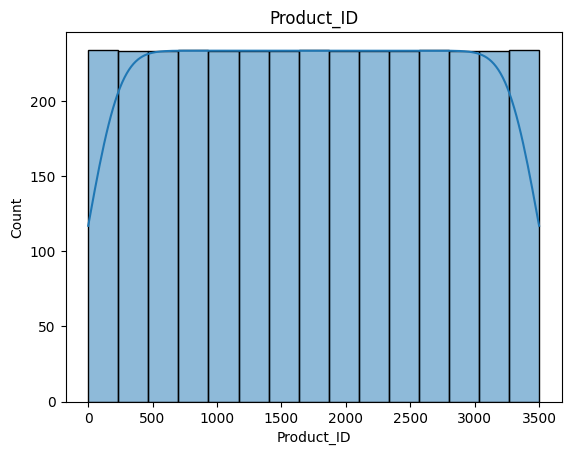

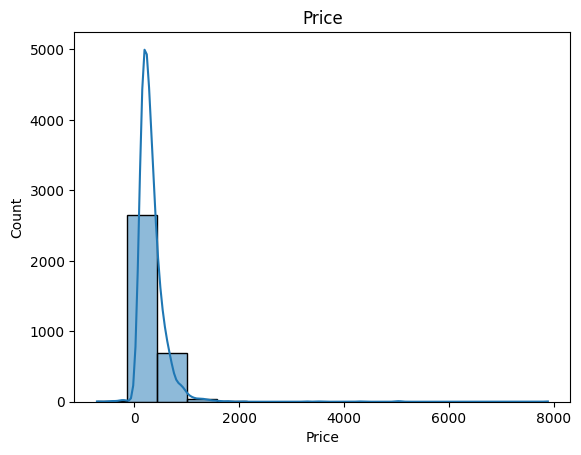

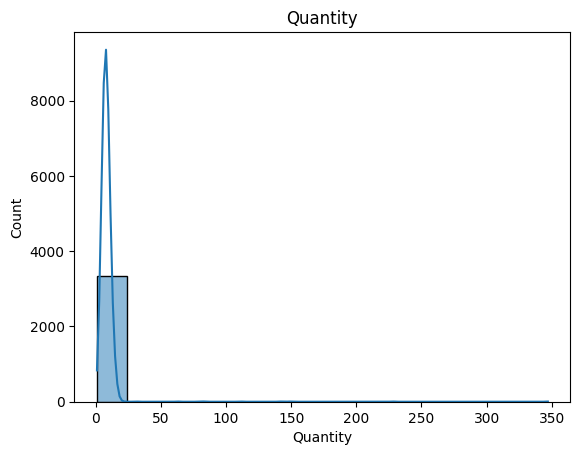

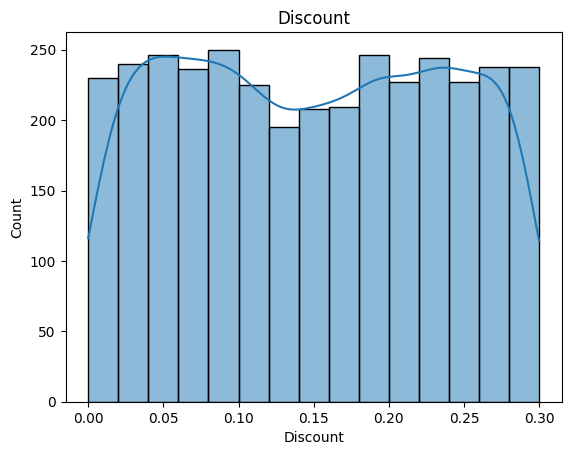

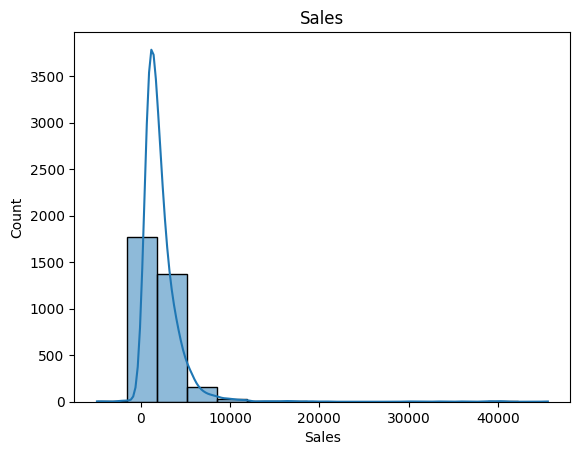

In [10]:
for col in numeric_cols:
    sns.histplot(df[col],bins=15,kde=True)
    plt.title(col)
    plt.show()

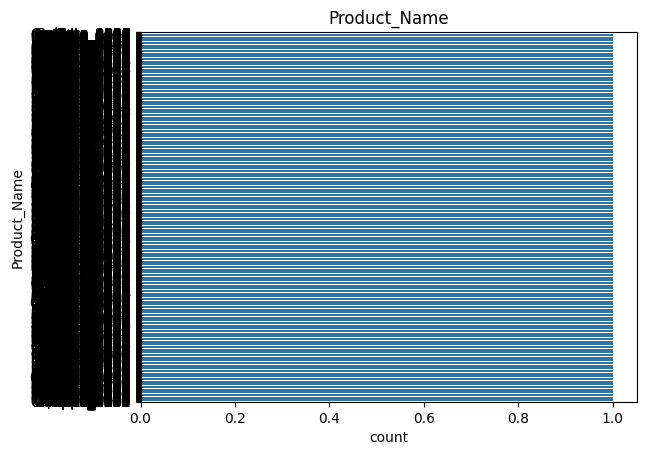

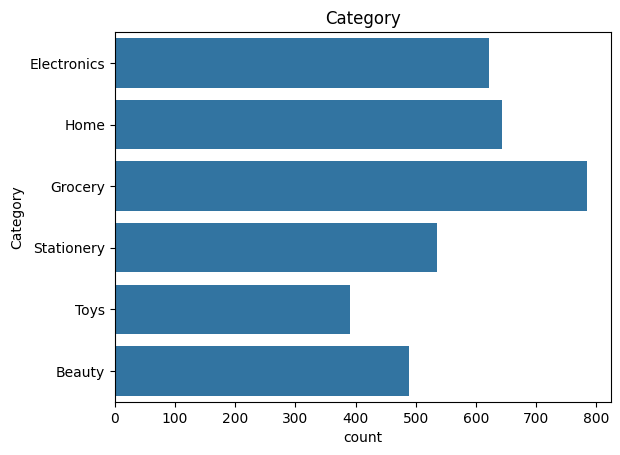

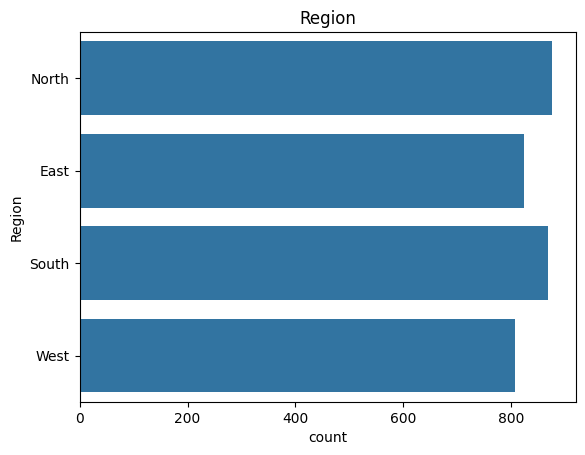

In [11]:
for col in categorical_cols:
    sns.countplot(df[col])
    plt.title(col)
    plt.show()

<Axes: >

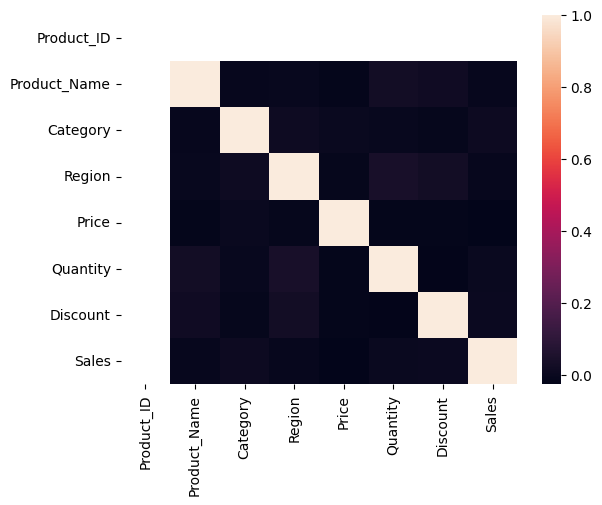

In [12]:
sns.heatmap(df.isnull().corr())

In [13]:
df.isnull().sum()

Product_ID        0
Product_Name     35
Category         36
Region          127
Price            97
Quantity        142
Discount         41
Sales           149
dtype: int64

In [14]:
df['Product_Name']

0                NaN
1         Gamma_2457
2          Beta_2233
3       Omicron_1946
4          Zeta_0310
            ...     
3495       Beta_1096
3496       Beta_1131
3497      Delta_1295
3498      Delta_0861
3499      Gamma_3175
Name: Product_Name, Length: 3500, dtype: object

In [15]:
df.to_csv('product_sales.csv',index=False)

In [16]:
df['Product_Name']=df['Product_Name'].fillna(df['Product_Name'].mode()[0])
df['Product_Name'].isna().sum()

np.int64(0)

In [17]:
df['Category'].isnull().sum()

np.int64(36)

In [18]:
df['Category']

0       Electronics
1              Home
2           Grocery
3       Electronics
4        Stationery
           ...     
3495        Grocery
3496        Grocery
3497           Home
3498         Beauty
3499    Electronics
Name: Category, Length: 3500, dtype: object

In [19]:
#df['Category']=df['Category'].dropna().reset_index(drop=True)

In [20]:
df['Category']=df['Category'].fillna(df['Category'].mode()[0])

In [21]:
df['Category'].isnull().sum()

np.int64(0)

In [22]:
categorical_cols

Index(['Product_Name', 'Category', 'Region'], dtype='object')

In [23]:
df['Region'].isnull().sum()

np.int64(127)

In [24]:
df['Region']=df['Region'].fillna(df['Region'].mode()[0])

In [25]:
df['Region'].isnull().sum()

np.int64(0)

In [26]:
numeric_cols

Index(['Product_ID', 'Price', 'Quantity', 'Discount', 'Sales'], dtype='object')

In [27]:
df['Price'].isna().sum()

np.int64(97)

In [28]:
df['Price']

0       179.41
1       389.76
2       388.89
3       120.33
4       281.19
         ...  
3495    218.93
3496       NaN
3497    377.83
3498    439.67
3499    229.11
Name: Price, Length: 3500, dtype: float64

In [29]:
df['Price']=df['Price'].fillna(df['Price'].median())

In [30]:
df['Price'].isna().sum()

np.int64(0)

In [31]:
df['Quantity'].isna().sum()

np.int64(142)

In [32]:
df['Quantity']=df['Quantity'].fillna(df['Quantity'].median())

In [33]:
df['Discount'].isnull().sum()

np.int64(41)

In [34]:
df['Discount']=df['Discount'].fillna(df['Discount'].median())

In [35]:
df['Discount'].isnull().sum()

np.int64(0)

In [36]:
df['Sales'].isna().sum()

np.int64(149)

In [37]:
df['Sales']=df['Sales'].fillna(df['Sales'].median())

In [38]:
df.isnull().sum()

Product_ID      0
Product_Name    0
Category        0
Region          0
Price           0
Quantity        0
Discount        0
Sales           0
dtype: int64

<Axes: >

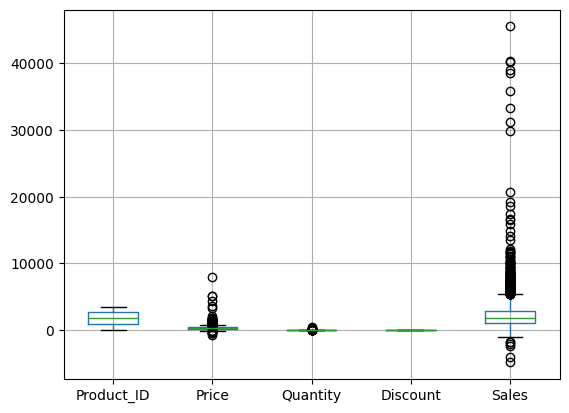

In [39]:
df.boxplot()

<Axes: ylabel='Price'>

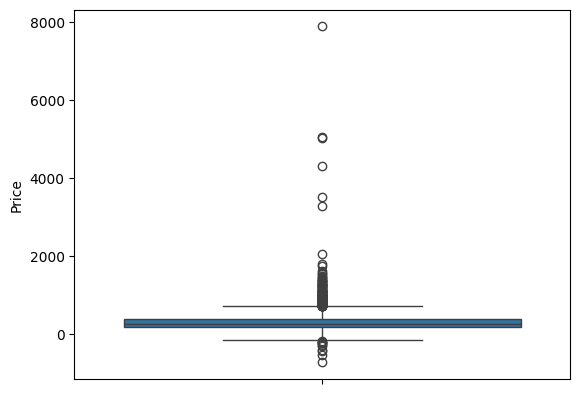

In [40]:
sns.boxplot(df['Price'])

In [41]:
def outlier_det(col):
    outlier=[]
    q1=np.percentile(df[col],25,method='midpoint')
    q3=np.percentile(df[col],75,method='midpoint')
    iqr=q3-q1
    lower=q1-1.5*iqr
    upper=q3+1.5*iqr
    outlier_condition=(df[col]<lower)|(df[col]>upper)
    outliers=df.loc[outlier_condition,col]
    outlier_indices=df.index[outlier_condition]
    return outliers,outlier_indices,lower,upper

In [42]:
outlier_price,outlier_price_indices,lower_price,upper_price=outlier_det('Price')

In [43]:
len(outlier_price)

179

In [44]:
df['Price']=df['Price'].clip(lower=lower_price,upper=upper_price)

<Axes: ylabel='Price'>

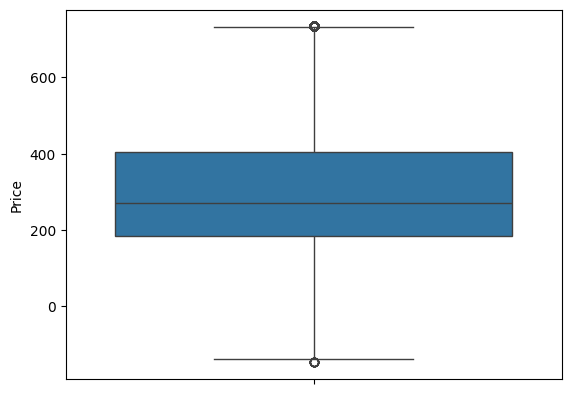

In [45]:
sns.boxplot(df['Price'])

<Axes: ylabel='Quantity'>

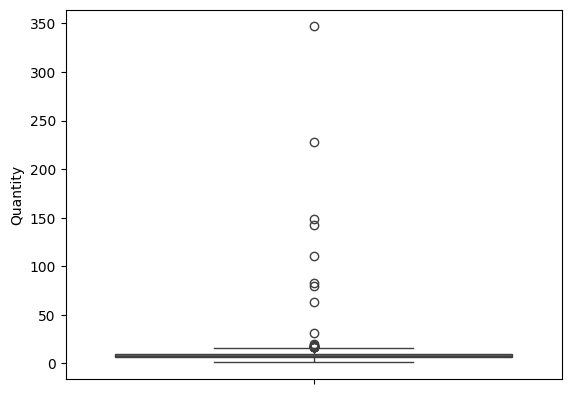

In [46]:
sns.boxplot(df['Quantity'])

In [47]:
outlier_quant,outlier_quant_indices,lower_quant,upper_quant=outlier_det('Quantity')

In [48]:
df['Quantity']=df['Quantity'].clip(lower=lower_quant,upper=upper_quant)

<Axes: ylabel='Quantity'>

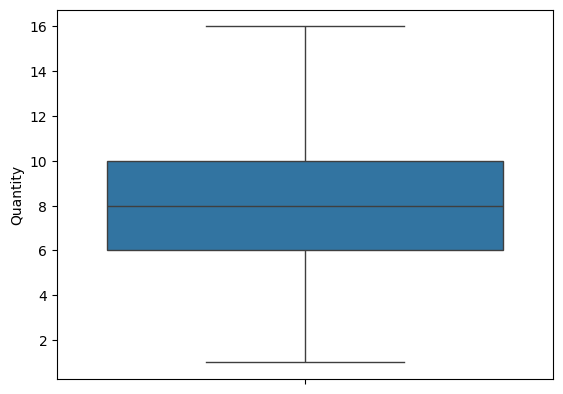

In [49]:
sns.boxplot(df['Quantity'])

<Axes: ylabel='Discount'>

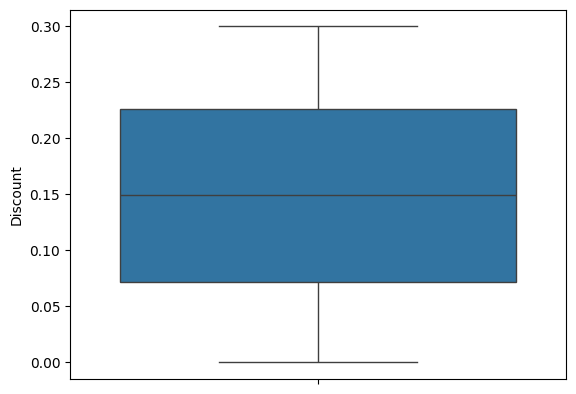

In [50]:
sns.boxplot(df['Discount'])

<Axes: ylabel='Sales'>

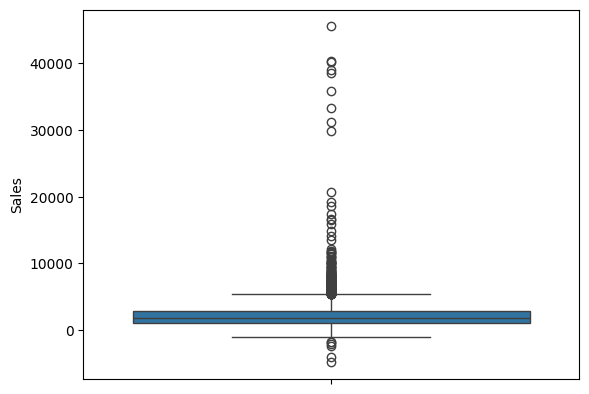

In [51]:
sns.boxplot(df['Sales'])

In [52]:
outlier_sales,outlier_sales_indices,lower_sales,upper_sales=outlier_det('Sales')

In [53]:
len(outlier_sales_indices)

205

In [54]:
df['Sales']=df['Sales'].clip(lower=lower_sales,upper=upper_sales)

<Axes: ylabel='Sales'>

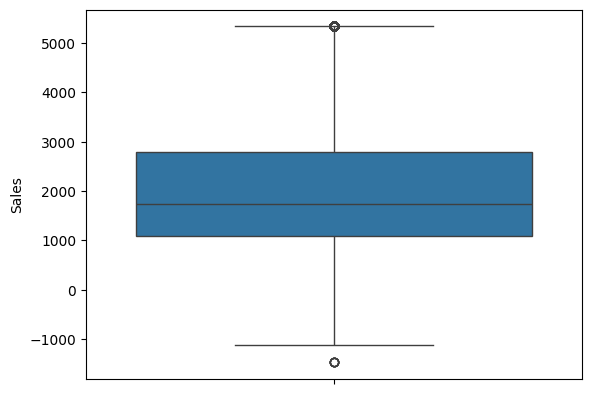

In [55]:
sns.boxplot(df['Sales'])

<Axes: xlabel='Sales', ylabel='Price'>

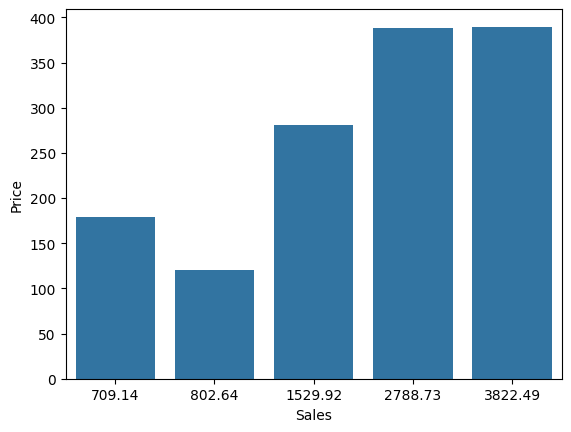

In [56]:
sns.barplot(x='Sales',y='Price',data=df.head())

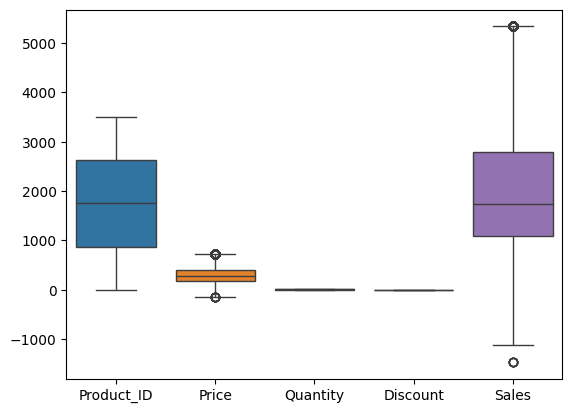

In [57]:
sns.boxplot(df)
plt.show()

In [58]:
df.to_csv('test.csv',index=False)